# VISUALISATION 
Bin data using smaller grids and rank them proportionally based on predictions and validation house values

IMPORT NECESSARY LIBRARIES

In [1]:
import glob
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

BIN RESULTS 
* Obtaining a housing wealth categories (shapefile of building each assigned a wealth class) 
* Map predictions onto area of 100x100 meter.
  1. Create spatial bins (use a mesh/ grid of 100x100m)
  2. Compute the coverage of each housing wealth category and score each area proportionally based on house value data. For instance a wealthier looking house value is as 2.5 higher than a visually poor house. The higher and the more in number the cell is covered by high wealthier roof the wealthier .
  3. Visualise on a scale of 0-1. 

In [77]:
# Load the buildings and Area of Interest (AoI) shapefiles
buildings = gpd.read_file("./prediction/Musanze_prediction_2008.shp")
#buildings = gpd.read_file("./prediction/Kigali_prediction_2008.shp")
AOI = gpd.read_file("./Study area/Musanze.shp") 
#AOI = gpd.read_file("./Study area/Kigali.shp") 

# Compute the area of each building polygon
buildings["area"] = buildings.geometry.area

# Step 1: Assign class labels
def assign_class(row):
    if (row["DN"] == 22 or row["DN"]==23):
        return 1  # wealthier
    elif row["DN"] == 201:
        return 2  # less wealthier
    else:
        return np.nan

# Step 2: Assign wealth scores based on validation data. How much wealthier is a house valued compared to low wealth house?
def assign_wealth(row):
    if (row["DN"] == 22 or row["DN"]==23):
        return 2.5
    elif row["DN"] == 201:
        return 1.0
    else:
        return np.nan

# Apply class and wealth assignments
buildings["class"] = buildings.apply(assign_class, axis=1)
buildings["wealth"] = buildings.apply(assign_wealth, axis=1)

# Filter only valid classes (optional but safer)
buildings = buildings.dropna(subset=["class"])

# Step 3: Create 100x100m grid bins
minx, miny, maxx, maxy = buildings.total_bounds
grid_size = 100  # meters

bins = []
for x in np.arange(minx, maxx, grid_size):
    for y in np.arange(miny, maxy, grid_size):
        grid_cell = box(x, y, x + grid_size, y + grid_size)
        if AOI.geometry.intersects(grid_cell).any():  # Only keep bins that intersect AOI
            bins.append(grid_cell)

# Create GeoDataFrame for the bins
bins_gdf = gpd.GeoDataFrame(geometry=bins, crs=buildings.crs)

# Step 4: Spatial join - assign each building to its corresponding bin
spatial_join = gpd.sjoin(buildings, bins_gdf, how="inner", predicate="within")

# Step 5: Compute total area of each class in each bin
bin_class_areas = spatial_join.groupby(["index_right", "class"])["area"].sum().unstack(fill_value=0)

# Ensure both class 1 and class 2 columns exist
bin_class_areas = bin_class_areas.reindex(columns=[1, 2], fill_value=0)

# Step 6: Compute total area per bin
bin_class_areas["total_area"] = bin_class_areas[1] + bin_class_areas[2]

# Avoid division by zero: filter out bins where total_area == 0
bin_class_areas = bin_class_areas[bin_class_areas["total_area"] > 0]

# Step 7: Compute weighted mean wealth score. A high wealth house is value around 2.5 times highter than low wealth house.
bin_class_areas["mwealth"] = ((bin_class_areas[1] * 2.5) + (bin_class_areas[2] * 1.0))/ bin_class_areas["total_area"]

# Step 9: Prepare final bin_means DataFrame
bin_means = bin_class_areas[["mwealth"]].reset_index()

# Step 10: Assign mwealth back to bins_gdf
bins_gdf = bins_gdf.reset_index().rename(columns={"index": "index_right"})
bins_gdf = bins_gdf.merge(bin_means, on="index_right", how="left")

# Step 11: Remove bins with no wealth data
bins_gdf = bins_gdf.dropna(subset=["mwealth"])

# Step 12: Save the final result
output_path = "./gridded_wealth/binned_wealth_musanze_2008.shp"
bins_gdf.to_file(output_path)

print(f"Processing complete! Binned wealth shapefile saved to {output_path}")

C:\Users\enyan\AppData\Local\Temp\ipykernel_17956\3873205519.py:78: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  bins_gdf.to_file(output_path)


Processing complete! Binned wealth shapefile saved to ./gridded_wealth/binned_wealth_musanze_2008.shp


READ  AND PREVIEW RESULTS 

In [79]:
data=gpd.read_file('./gridded_wealth/binned_wealth_musanze_2008.shp')
data.head()

,index_righ,mwealth,geometry
0,1,1.0,"POLYGON ((450631.500 4840519.500, 450531.500 4..."
1,2,1.0,"POLYGON ((450631.500 4840619.500, 450531.500 4..."
2,3,1.0,"POLYGON ((450631.500 4840719.500, 450531.500 4..."
3,4,1.0,"POLYGON ((450631.500 4840819.500, 450531.500 4..."
4,8,1.0,"POLYGON ((450731.500 4840419.500, 450631.500 4..."


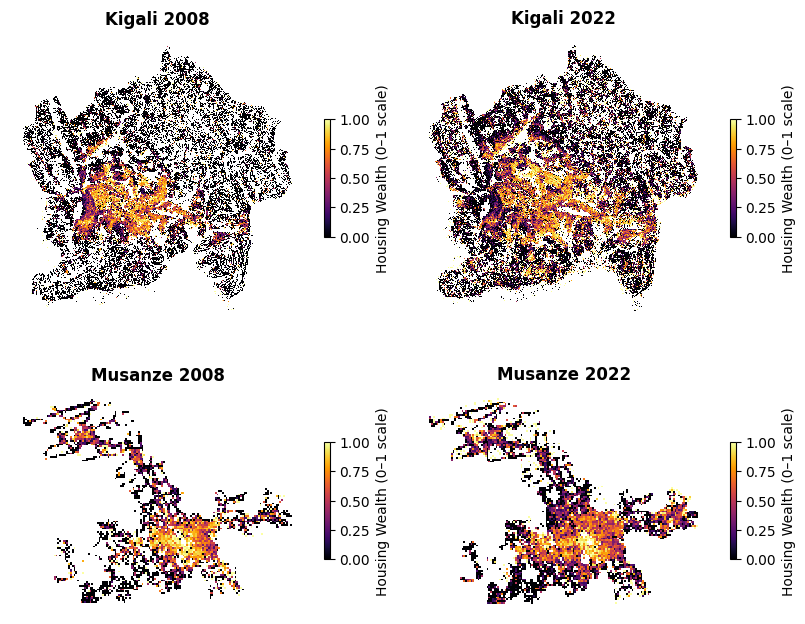

In [91]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Load datasets
data1 = gpd.read_file('./gridded_wealth/binned_wealth_kigali_2008.shp')
data2 = gpd.read_file('./gridded_wealth/binned_wealth_kigali_2022.shp')
data3 = gpd.read_file('./gridded_wealth/binned_wealth_musanze_2008.shp')
data4 = gpd.read_file('./gridded_wealth/binned_wealth_musanze_2022.shp')

# Function to process data
def process_data(data):
    """Normalize mwealth to 0–1 scale"""
    data = data.copy()
    min_val = data['mwealth'].min()
    max_val = data['mwealth'].max()
    data['value'] = (data['mwealth'] - min_val) / (max_val - min_val)
    return data

# Process all datasets
data1 = process_data(data1)
data2 = process_data(data2)
data3 = process_data(data3)
data4 = process_data(data4)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# Visualization settings
cmap = "inferno"
alpha = 1
dpi = 1200

# Plot data
titles = ['Kigali 2008', 'Kigali 2022', 'Musanze 2008', 'Musanze 2022']
datasets = [data1, data2, data3, data4]

for ax, data, title in zip(axes.flat, datasets, titles):
    data.plot(column='value', ax=ax, cmap=cmap, alpha=alpha,
              legend=True, vmin=0, vmax=1,
              legend_kwds={'shrink': 0.4, 'label': 'Housing Wealth (0–1 scale)'})
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_axis_off()

# Save and display
plt.savefig('./gridded_wealth/Housing wealth2008-2022 pattern.jpg', dpi=dpi)
plt.show()
